[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AprendizajeProfundo/minucurso-ciencia-de-datos/blob/main/Pyro/Panel_Pyro.ipynb)

# <span style="color:#F72585"><center>Programación probabilística en Pyro</center></span>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Estadistica_Bayesiana/Imagenes/Monedas.jpg" width="800" height="400" align="center" /> 
</center>   
</figure>
<center>

Fuente: <a href="https://commons.wikimedia.org/wiki/File:Monedas_Varias.jpg">ViajeroExtraviado</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

</center>


## <span style="color:#4361EE">¿Qué es?</span> 

La programación probabilística nos ayuda a crear modelos probabilísticos y hacer inferencia a partir de ellos de manera automática. 

## <span style="color:#4361EE">Motivación para y la Programación Probabilística</span> 

1. **Ajustar modelos estadísticos Bayesianos poderosos** 
2. **El Proceso**: *A)Crea un modelo estadístico; B) Corre la inferencia del modelo; C) Evalúa;*
3. **Dificultades con las herramientas existentes para abordar los modelos de interés actuales** 
4. **Usabilidad**: *propósito general, Lenguaje de modelamiento claro, integración*
5. **Escalabilidad**: *Complejidad del modelo, número de parámetros, tamaño de los datos*
6. **Eficiencia**: *Tamaños de muestra altamente efectivos, iteraciones rápidas, baja memoria*
7. **Robustez**: *estructura del modelo (por ejemplo geometría posterior), rutinas numéricas*

## <span style="color:#4CC9F0">Pyro</span>


Pyro es un lenguaje de programación probabilística de alto nivel escrito en Python y compilada sobre [PyTorch](https://pytorch.org/) que combina el estado del arte de técnicas de IA con la experiencia y habilidades de científicos de datos para unificar el Aprendizaje Profundo con el modelamiento Bayesiano. El usuario puede especificar o crear modelos estadísticos y hacer Inferencia Bayesiana a partir de ellos. Si no tiene familiaridad con [PyTorch](https://pytorch.org/) le recomendamos que se familiarice con el lenguaje por medio del tutorial [learn the basics](https://pytorch.org/tutorials/beginner/basics/intro.html).


<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Estadistica_Bayesiana/Imagenes/pyro_logo.png" width="600" height="300" align="center" /> 
</center>   
</figure>
<center>

Fuente: [Pyro](https://pyro.ai/)

</center>


- Universal: Pyro puede representar cualquier distribución de probabilidad computable
- Escalable: Pyro escala a grandes conjuntos de datos con poca sobrecarga.
- Minimalista: Pyro está implementado con un pequeño  y poderoso nucleo de abstracciones
- Flexible: Pyro tiene como objetivo la automatización cuando lo desee, el control cuando lo necesite.

## <span style="color:#4361EE">Primitives</span>

Uno de los objetivos de Pyro es lograr que el código sea lo más elegante e intuitivo posible, las `primitives` buscan alcanzar ese objetivo, entre ellas encontramos:

- `pyro.sample`: Guarda en Python un generador de números aleatorios sobre la distribución o función que se le indique. El resultado de esta declaración es un tensor de Pytorch. Es posible ajustar los parámetros de la distribución a los datos que tenemos disponibles por medio de `obs`.

    ```
    x = pyro.sample('x',dist.Normal(0,1),obs=data)
    ```

- `pyro.param`: Permite registrar parámetros que se pueden aprender. Indicamos un nombre y un valor inicial que por lo general se usa solo la primera vez antes de iniciar un proceso de aprendizaje. El argumento `constraint` nos permite restringir nuestro parámetro a los valores que consideremos convenientes 
    ```
    y = pyro.param('y',torch.ones(5), constraint=positive)
    ```

- `pyro.plate`: Se usa para indicar que dos variables son condicionalmente independientes o que son 'intercambiables'. Podemos usar esta declaración de dos maneras distintas:
    ```
    with pyro.plate('data',len(data),batch_size) as ids:
        pyro.sample('data',fun(x),obs=data[ids])

    ```
    En este caso podemos generar múltiples muestras en paralelo a partir de múltiples datos. Es decir, nos permite tener grandes lotes de datos y operar en paralelo sobre cada uno de ellos. En ocasiones buscamos una estructura más dinámica y recorrer secuencialmente cada elemento del lote, para esto usamos:
    ```
    for i in pyro.plate('data',len(data),batch_size) as ids:
        pyro.sample('data',fun(x),obs=data[ids])

    ```    
      

## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


### <span style="color:#4CC9F0">Los datos</span>


Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas después de un periodo de preparación para realizar el SAT. Este ejemplo es tratado en `gelman1995bayesian`



|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A  |28 | 15|
|B  |8  |10 |
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align*}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\propto 1\\
\tau &\propto 1
\end{align*}
$$


In [72]:
# Importamos las librerías necesarias
import numpy as np
import torch
#!pip install pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
import pyro.distributions.constraints as constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO


In [73]:
# Los datos
J = 8 #Número de escuelas
y = torch.tensor([28, 8, -3, 7, -1, 1, 18, 12]).type(torch.Tensor) #Estimaciones de los efectos del tratamiento
sigma = torch.tensor([15, 10, 16, 11, 9, 11, 10, 18]).type(torch.Tensor) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 

{'J': 8,
 'y': tensor([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
 'sigma': tensor([15., 10., 16., 11.,  9., 11., 10., 18.])}

## <span style="color:#4361EE">Implementación del modelo estadístico en Pyro</span>

### <span style="color:#4CC9F0">Modelo</span>

In [74]:
def model(J,y,sigma):
    eta = pyro.sample('eta',dist.Normal(torch.zeros(J),torch.ones(J)))
    mu = pyro.param('mu', torch.ones(J))
    tau = pyro.param('tau', torch.ones(J))
    thetas = mu + tau*eta
    return pyro.sample("y",dist.Normal(thetas,sigma),obs=y)   

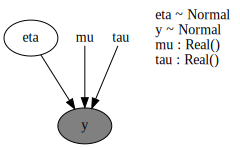

In [75]:
pyro.render_model(model,model_args=(J,y,sigma),render_distributions=True,render_params=True)

En este código los prámetros que serán muestreados son los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo, $\mu$ y $\tau$. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

### <span style="color:#4CC9F0">Guide</span>


En `guide` introduciremos una distribución variacional que contenga los parámetros variacionales. Con esta distribución buscamos llegar a la mejor aproximación de la posterior

*** Importante ***

Tenga en cuenta que si el modelo contiene una variable `pyro.sample('z_1',...)`, la guía necesita tener una variable `pyro.sample('z_1',...)`. No es necesario que ambas variables sigan la misma distribución o valor inicial, pero sí que tengan el mismo nombre y pertenezcan al mismo 'primitive' 



In [76]:
def guide_model(J,y,sigma):
    tau= pyro.param('tau',torch.ones(1))
    mu= pyro.param('mu',torch.ones(1))
    eta = pyro.sample('eta',dist.Normal(torch.zeros(J),torch.ones(J)))
    

## <span style="color:#4361EE">Compilación del modelo</span>


`NUTS` es una herramienta para hacer inferencia bayesiana usando 'No-U-Turn Sampler' para correr eficientemente el Hamiltonian Montecarlo. `MCMC` hace referencia a Markov chain Monte Carlo. En este caso lo usaremos para acceder a los algoritmos de inferencia MCMC disponibles en Pyro.

In [77]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(J,y,sigma)

Sample: 100%|██████████| 800/800 [00:19, 40.20it/s, step size=7.39e-01, acc. prob=0.886]


In [78]:
mcmc.summary(prob=0.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
    eta[0]      0.11      1.01      0.11     -1.70      2.09    978.16      1.00
    eta[1]      0.02      1.00     -0.00     -1.77      2.04    839.36      1.00
    eta[2]     -0.03      1.07     -0.06     -2.22      1.89    873.82      1.00
    eta[3]      0.08      1.06      0.05     -1.76      2.30   1182.37      1.00
    eta[4]     -0.04      1.00      0.01     -1.79      2.25    646.31      1.00
    eta[5]      0.05      0.94      0.03     -1.87      1.76    894.70      1.00
    eta[6]      0.24      1.00      0.24     -1.78      2.09    707.92      1.00
    eta[7]      0.03      1.00      0.04     -2.02      1.96    831.52      1.00

Number of divergences: 0


Una vez el modelo es compilado, se pueden generar muestras cuando se desee.

In [79]:
samples=mcmc.get_samples()
posterior_predictive = Predictive(model, samples)(
    schools_dat["J"], schools_dat["y"], schools_dat["sigma"]
)
prior = Predictive(model, num_samples=500)(
    schools_dat["J"], schools_dat["y"], schools_dat["sigma"]
)

In [80]:
import arviz as az 
import xarray


In [81]:
pyro_data = az.from_pyro(
    mcmc,
    posterior_predictive = posterior_predictive,
    coords={'school': schools },
    prior=prior,
    dims={
        "theta": ["school"],
        'y': ['school'],
        'eta': ['school'],
    }
)


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


In [82]:
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

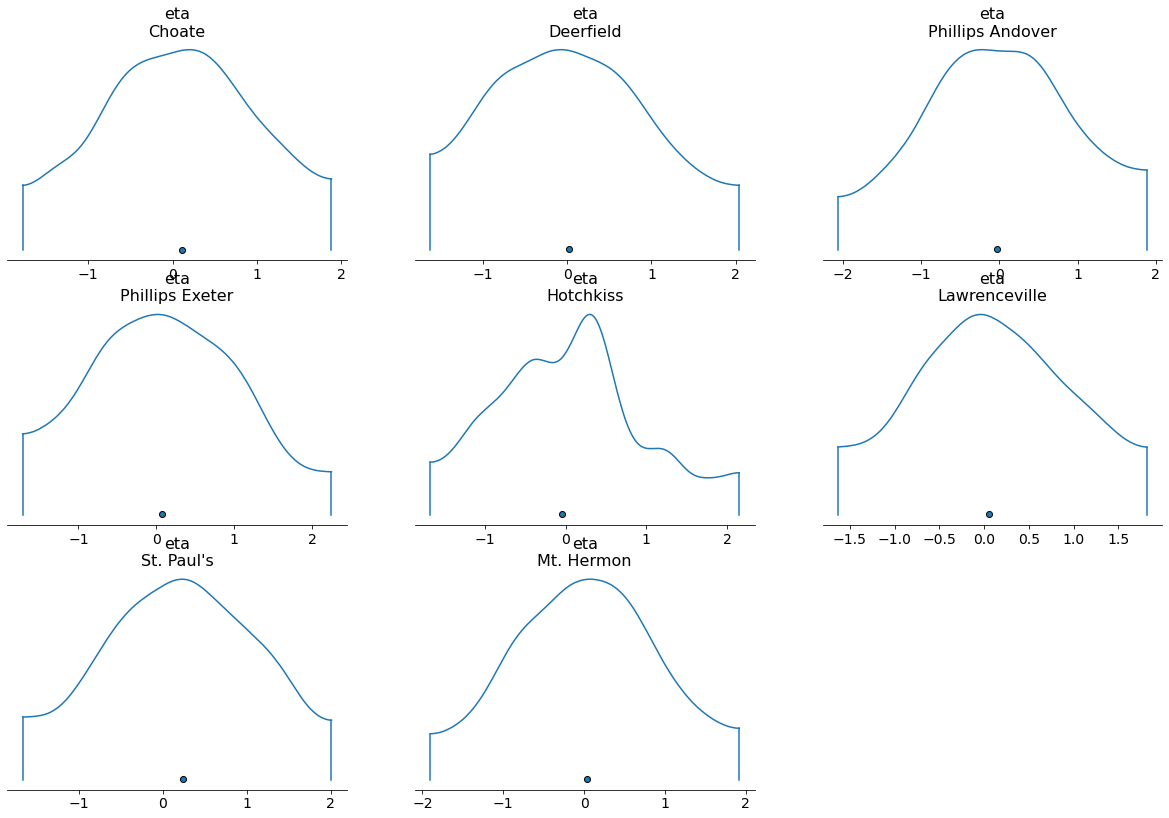

In [83]:
az.plot_density(pyro_data);


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>]], dtype=object)

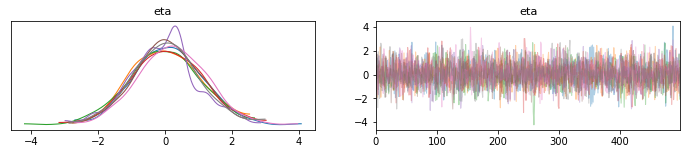

In [84]:
az.plot_trace(pyro_data)

## <span style="color:#4361EE">Optimización del modelo</span>


Para la optimización del modelo usaremos Adam (Adaptative moment estimation)

In [85]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
#Fijamos el algoritmo de inferencia con base el el modelo optimizado
svi = SVI(model, guide_model, optimizer, loss=Trace_ELBO())